In [22]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [23]:
# Reading the file csv into dataframe

data = pd.read_csv('CE802_P2_Data/CE802_P2_Data.csv')

# Verify the data load 
data.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,20,-21.42,13.1,464.04,-6.10,-4.50,-18.66,27.54,20.1,-7.08,-16.32,365,0.47,3.40,-3.90,False
1,20,-27.12,13.5,299.04,-6.18,-4.91,-18.66,27.44,18.2,-12.84,-11.07,205,-129.53,7.12,NaN,False
2,20,-33.87,10.5,854.04,-9.32,-7.16,-18.66,25.44,11.9,-5.46,-11.01,330,-44.53,4.62,-3.84,False
3,20,-25.38,19.4,809.04,-12.69,-4.95,-23.66,25.54,19.6,-11.31,-7.53,215,-54.53,2.26,NaN,False
4,20,-23.22,16.0,359.04,-7.70,-4.36,-8.66,26.64,25.8,-12.69,-10.20,85,-134.53,-0.20,-7.76,True


In [3]:
# retrieve the information for feature names and data rows
# There are 15 features and 1 Target Variable, all features are numerical as indicated by dtype and Target variable is boolean,
# The class variable indicate the task is a Classification problem, also Supervised as we are provided with labelled data for the learning task
# There are 1500 data samples 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      1500 non-null   int64  
 1   F2      1500 non-null   float64
 2   F3      1500 non-null   float64
 3   F4      1500 non-null   float64
 4   F5      1500 non-null   float64
 5   F6      1500 non-null   float64
 6   F7      1500 non-null   float64
 7   F8      1500 non-null   float64
 8   F9      1500 non-null   float64
 9   F10     1500 non-null   float64
 10  F11     1500 non-null   float64
 11  F12     1500 non-null   int64  
 12  F13     1500 non-null   float64
 13  F14     1500 non-null   float64
 14  F15     750 non-null    float64
 15  Class   1500 non-null   bool   
dtypes: bool(1), float64(13), int64(2)
memory usage: 177.4 KB


In [4]:
# We will now check the numper of samples beloning to each category.
# This is important to verify if the dataset is balanced or unbalanced
# the value TRUE in the data means :Yes, they suffered from diabetes


print('Non Diabetic Data :{} Rows, {:.2f}%'.format(data.Class.value_counts()[0], data.Class.value_counts()[0]/len(data)*100))
print('Diabetic Data : {} Rows, {:.2f}%'.format(data.Class.value_counts()[1], data.Class.value_counts()[1]/len(data)*100))

# The data is not highly imbalanced, the data in each class helps in determining the evaluation metrics, we do not prefer accuracy for highly imbalanced datasets
# For our case , i have chosen to evaluate our models using Classification report capturing Accuracy, Precision, Recall and F1-Score

Non Diabetic Data :809 Rows, 53.93%
Diabetic Data : 691 Rows, 46.07%


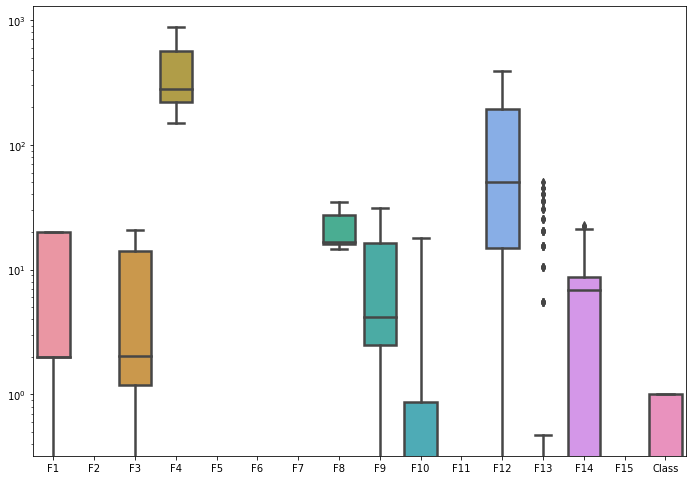

In [38]:
# To check outliers 
# We can observe outliers only in the F13

a_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a_dims)
g = sns.boxplot(data=data,linewidth=2.5,ax=ax)
g.set_yscale("log")

In [5]:

# Created a function for stratified split of Train and Test Data in 80:20 ratio on 'Class' 
from sklearn.model_selection import train_test_split

def split_train_test(df):
    '''
    function for stratified split of Train and Test Data in 80:20 ratio on 'Class'
    '''
    train_X = df.drop(columns=['Class'])
    train_Y = df['Class']
    train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y, test_size=0.2, random_state=0, shuffle=True, stratify= df['Class'])

    # shape of train and test splits
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)
    return train_x, train_y, test_x, test_y


train_x, train_y, test_x, test_y = split_train_test(data)
train_x['Class'] = train_y
test_x['Class'] = test_y

(1200, 15) (1200,) (300, 15) (300,)


In [6]:
def df_to_array(df):
    
    '''
    function to load the dataframe into data and target arrays
    Encode the CLass variable with 0 and 1 for False and True values respectively
    '''
    X = df.loc[:, df.columns != 'Class'].to_numpy()
    y = df.loc[:, 'Class'].to_numpy()
    y = np.where(y == False, 0 ,1)
    print(X.shape, y.shape)
    return X , y

data_arr, target_arr = df_to_array(train_x)
data_arr_test, target_arr_test = df_to_array(test_x)


(1200, 15) (1200,)
(300, 15) (300,)


Visualize the Features

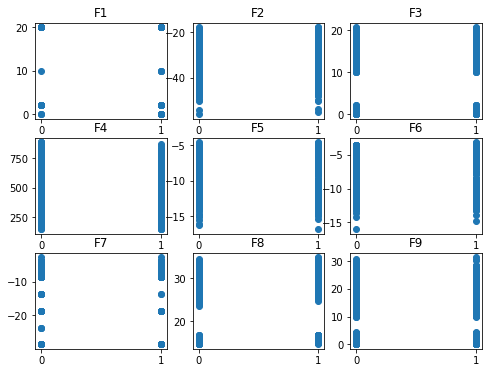

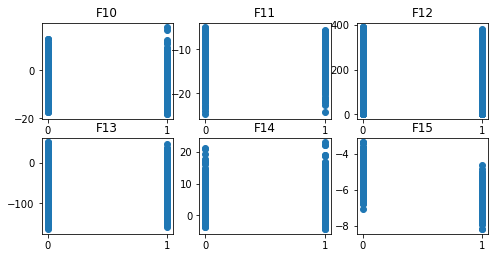

In [7]:
# The feature values are not in specific range, since few models work better with normalized data, we are checking if the data features requires the normalization
# We would apply standardization on our Features later in the notebook

def plot_features(p_d):
    ''' 
    Function to plot scatterplot of Target Variable and Features
    '''

    plt.figure(figsize=(8,6))
    col_num = p_d.shape[1]
    last = col_num - 9
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.scatter(target_arr,p_d[:,i])
        plt.xticks([0, 1])
        plt.title("F"+str(i+1))
        
    plt.figure(figsize=(8,6))
    for i in range(last):
        plt.subplot(3, 3, i+1)
        plt.scatter(target_arr,p_d[:,i+9])
        plt.xticks([0, 1])
        plt.title("F"+str(i+10))
    
plot_features(data_arr)

Missing Values

In [8]:
# As from below check we can see F15 has 750 missing values
print((np.sum(np.isnan(data_arr), 0)))
print('Columns',np.where(np.sum(np.isnan(data_arr),0) != 0))

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0 593]
Columns (array([14], dtype=int64),)


Create a function to return the data array with or without F15

In [9]:
# To Hanldle the data with missing values 
# we will create a function to return the data with or without F15 feature

def data_with_f15(df, val = True):
    '''
    val : True indicates the numpy array conatins F15 attribute
    '''
    if val:
        return df.loc[:, ~df.columns.isin(['Class'])].to_numpy()
    return df.loc[:, ~df.columns.isin(['Class', 'F15'])].to_numpy()


Create the Pipeline for data processing before sending the parameters to Models

In [10]:
# create the scikit pipeline to standardize the features
# Pipeline1 (num_pipeline) : Scale the numerical parameters of data without F15 feature, in our case all features are numerical
# Pipeline2 (num_f15_pipeline_median) : Impute the missing values of F15 feature with the median and then scale them
# Pipeline3 (num_f15_pipeline_knn) : Impute the missing values of F15 feature with the knn and then scale them
# Use above Pipeliness to Fit and Transform the Training data
# Use above Pipeliness to Transform the Test data 

from sklearn.impute import KNNImputer
knnimputer = KNNImputer(n_neighbors=3, weights="uniform")

num_pipeline = Pipeline([('scale', StandardScaler())])

num_f15_pipeline_median = Pipeline([('imputer', SimpleImputer(strategy="median")),('scale', StandardScaler())])

num_f15_pipeline_knn = Pipeline([('imputer', knnimputer), ('scale', StandardScaler())])

data_arr_scaled = num_pipeline.fit_transform(data_with_f15(train_x, False))
data_arr_scaled_with_f15_median = num_f15_pipeline_median.fit_transform(data_with_f15(train_x, True))
data_arr_scaled_with_f15_knn = num_f15_pipeline_knn.fit_transform(data_with_f15(train_x, True))

data_arr_scaled_test = num_pipeline.transform(data_with_f15(test_x, False))
data_arr_scaled_with_f15_median_test = num_f15_pipeline_median.transform(data_with_f15(test_x, True))
data_arr_scaled_with_f15_knn_test = num_f15_pipeline_knn.transform(data_with_f15(test_x, True))

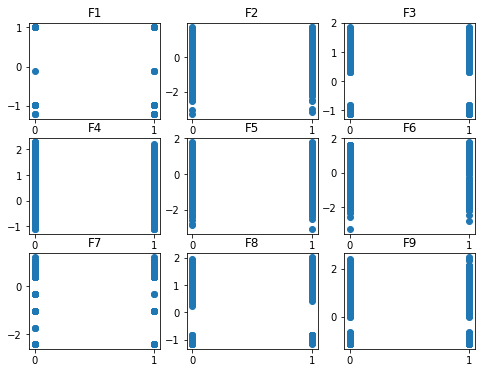

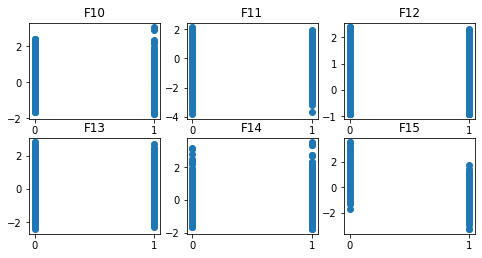

In [11]:
# Verify the scaled vectors
plot_features(data_arr_scaled_with_f15_median)

Train Models

In [12]:
# In the below code, we are
# Training using a model object
# Choosing the best parameters for the model using Grid Search CV
# Performing an outer cross validation loop and nested parameter tuning 

def fit_model_with_best_parameters(model, params, X, y):
    '''
    Function to Choose the best parameters for the model using Grid Search CV and perform Cross Validation
    '''
    grid_search_cv = GridSearchCV(model, params)
    grid_search_cv.fit(X,y)
    scores = cross_val_score(grid_search_cv, X, y, cv=10, scoring=make_scorer(f1_score))  # cross-validation
    # print('CV List of F1 scores :', scores)
    print('Mean F1 Score :',scores.mean())
    print(grid_search_cv.best_estimator_)
    return grid_search_cv.best_estimator_, grid_search_cv.best_params_

In [94]:
# function to plot confusion Matrix

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    """
    This function prints and plots the confusion matrix.
    """
   
    ax = sns.heatmap(cm, annot=True, fmt = 'd' ,cmap='Blues')

    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
# function to report accuracies for oour experiments    
def report(model, params, train = True, plot_cm = False, create_cls_report = False, X = '', y = '',grid_search = True):
    '''
    Function report the F1 score, Confusion Matrix, Classification Report for a given model 
    '''
    if not train:
        y_pred = model.predict(X)
        print(15*'*')
        print("Confusion Matrix" )
        print(15*'*')
        cm = confusion_matrix(y, y_pred)
        plot_confusion_matrix(cm,['Non Diabetic','Diabetic'])
        
        print(15*'*')
        print("Classification Report " )
        print(15*'*')
        print(classification_report(y, y_pred))
        return True
        
    if train:
        print(15*'*')
        print("TRAINING" )
        print(15*'*')

        print(15*'*')
        print("Model tuned with data not containing F15" )
        print(15*'*')
        # model learning without F15
        if grid_search:
            best, best_params = fit_model_with_best_parameters(model, params, data_arr_scaled, target_arr)
        else:
            best = model
            scores = cross_val_score(best, data_arr_scaled, target_arr, cv=10, scoring=make_scorer(f1_score))
            print("Cross Validation Score:", scores.mean())
            best.fit(data_arr_scaled, target_arr)
            y_pred = best.predict(data_arr_scaled_test)
            print("Test F1 Score: ",f1_score(target_arr_test, y_pred))

        print(15*'*')
        print("Model tuned with data containing F15 imputed with Median" )
        print(15*'*')
        # model learning with F15 missing values with Median
        if grid_search:
            best_wf15_median, best_params_wf15_median = fit_model_with_best_parameters(model, params, data_arr_scaled_with_f15_median, target_arr)
        else:
            best_wf15_median = model
            best_wf15_median.fit(data_arr_scaled_with_f15_median, target_arr)
            y_pred = best_wf15_median.predict(data_arr_scaled_with_f15_median_test)
            scores = cross_val_score(best_wf15_median, data_arr_scaled_with_f15_median, target_arr, cv=10, scoring=make_scorer(f1_score))
            print("Cross Validation Score:", scores.mean())
            print("Test F1 Score: ",f1_score(target_arr_test, y_pred))

        print(15*'*')
        print("Model tuned with data containing F15 imputed with knn" )
        print(15*'*')
        if grid_search:
            best_wf15_knn, best_params_wf15_knn = fit_model_with_best_parameters(model, params, data_arr_scaled_with_f15_knn, target_arr)
        else:
            best_wf15_knn = model
            scores = cross_val_score(best_wf15_knn, data_arr_scaled_with_f15_knn, target_arr, cv=10, scoring=make_scorer(f1_score))
            print("Cross Validation Score:", scores.mean())
            best_wf15_knn.fit(data_arr_scaled_with_f15_knn, target_arr)
            y_pred = best_wf15_knn.predict(data_arr_scaled_with_f15_knn_test)
            print("Test F1 Score: ",f1_score(target_arr_test, y_pred))

    if grid_search:
        print(15*'*')
        print("VALIDATE" )
        print(15*'*')

        print(15*'*')
        print("F1 Score for data not containing F15" )
        print(15*'*')

        y_pred = best.predict(data_arr_scaled_test)
        print(f1_score(target_arr_test, y_pred))
        
        if plot_cm:
            print(15*'*')
            print("Confusion Matrix for data not containing F15" )
            print(15*'*')
            cm = confusion_matrix(target_arr_test, y_pred)
            plot_confusion_matrix(cm,['Non Diabetic','Diabetic'])
            
        if create_cls_report:
            print(15*'*')
            print("Classification Report for data not containing F15" )
            print(15*'*')
            print(classification_report(target_arr_test, y_pred))

        print(15*'*')
        print("F1 Score for data containing F15 imputed with Median" )
        print(15*'*')
        

        y_pred = best_wf15_median.predict(data_arr_scaled_with_f15_median_test)
        print(f1_score(target_arr_test, y_pred))
        
        if plot_cm:
            print(15*'*')
            print("Confusion Matrix for data containing F15 imputed with Median" )
            print(15*'*')
            cm = confusion_matrix(target_arr_test, y_pred)
            plot_confusion_matrix(cm,['Non Diabetic','Diabetic'])
            
        if create_cls_report:
            print(15*'*')
            print("Classification Report for data containing F15 imputed with Median" )
            print(15*'*')
            print(classification_report(target_arr_test, y_pred))

        print(15*'*')
        print("F1 Score for data containing F15 imputed with knn" )
        print(15*'*')

        y_pred = best_wf15_knn.predict(data_arr_scaled_with_f15_knn_test)
        print(f1_score(target_arr_test, y_pred))
        
        if plot_cm:
            print(15*'*')
            print("Confusion Matrix for data containing F15 imputed with knn" )
            print(15*'*')
            cm = confusion_matrix(target_arr_test, y_pred)
            plot_confusion_matrix(cm,['Non Diabetic','Diabetic'])
            
        if create_cls_report:
            print(15*'*')
            print("Classification Report for data containing F15 imputed with knn" )
            print(15*'*')
            print(classification_report(target_arr_test, y_pred))
    if train:
        return best, best_wf15_median, best_wf15_knn

Model Training

Decision Tree Classfier

In [53]:

from sklearn.tree import DecisionTreeClassifier

params = {
          'min_samples_split': [10, 60, 4],
          'max_depth' : [6,7,8], 
          'min_samples_leaf': [8,10,12],
          'criterion': ['gini', 'entropy']
          }

model = DecisionTreeClassifier(random_state=42)
        
best_dt, best_dt_wf15_median, best_dt_wf15_knn = report(model, params)

***************
TRAINING
***************
***************
Model tuned with data not containing F15
***************
Mean F1 Score : 0.7283656096241983
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=12,
                       min_samples_split=10, random_state=42)
***************
Model tuned with data containing F15 imputed with Median
***************
Mean F1 Score : 0.7798162509746985
DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, min_samples_split=10,
                       random_state=42)
***************
Model tuned with data containing F15 imputed with knn
***************
Mean F1 Score : 0.7573600729170946
DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, min_samples_split=10,
                       random_state=42)
***************
VALIDATE
***************
***************
F1 Score for data not containing F15
***************
0.7307692307692306
***************
F1 Score for data containing F15 imputed with Median
***************
0.808988764044

***************
Confusion Matrix
***************


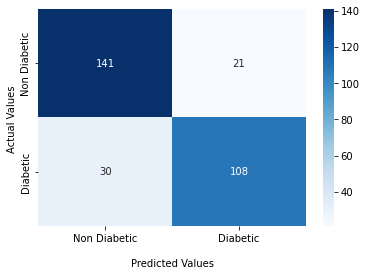

***************
Classification Report 
***************
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       162
           1       0.84      0.78      0.81       138

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



True

In [48]:
# Plot Confusion Matrix and Classification report for best model
report(best_dt_wf15_median, params,False,False,False,data_arr_scaled_with_f15_median_test,target_arr_test)

GaussianProcessClassifier

In [108]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RationalQuadratic


gpc = GaussianProcessClassifier(kernel=1*RationalQuadratic(1.0))
best_vc, best_vc_wf15_median, best_vc_wf15_knn = report(gpc, params,True,False,False,'','',False)


***************
TRAINING
***************
***************
Model tuned with data not containing F15
***************
Cross Validation Score: 0.8797517945887785
Test F1 Score:  0.8741258741258742
***************
Model tuned with data containing F15 imputed with Median
***************
Cross Validation Score: 0.8739622660994968
Test F1 Score:  0.8982456140350877
***************
Model tuned with data containing F15 imputed with knn
***************
Cross Validation Score: 0.8923940148310858
Test F1 Score:  0.8780487804878048


Supoort Vector Machine

In [ ]:

from sklearn.svm import SVC

params = {    'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','poly']
         }
model = SVC()
best_svc, best_svc_wf15_median, best_svc_wf15_knn = report(model, params)



***************
TRAINING
***************
***************
Model tuned with data not containing F15
***************
Mean F1 Score : 0.8715268073876755
SVC(C=1000, gamma=0.01)
***************
Model tuned with data containing F15 imputed with Median
***************
Mean F1 Score : 0.8748044523547535
SVC(C=1000, gamma=0.01)
***************
Model tuned with data containing F15 imputed with knn
***************
Mean F1 Score : 0.8775519427514427
SVC(C=1000, gamma=0.01)
***************
VALIDATE
***************
***************
F1 Score for data not containing F15
***************
0.8741258741258742
***************
F1 Score for data containing F15 imputed with Median
***************
0.9154929577464788
***************
F1 Score for data containing F15 imputed with knn
***************
0.8881118881118881


KNN CLassifier

In [103]:
from sklearn.neighbors import KNeighborsClassifier

params = {'n_neighbors' : range(1,31)}
model = KNeighborsClassifier()


best_knn, best_knn_wf15_median, best_knn_wf15_knn = report(model, params)

***************
TRAINING
***************
***************
Model tuned with data not containing F15
***************
Mean F1 Score : 0.6719681869011382
KNeighborsClassifier(n_neighbors=13)
***************
Model tuned with data containing F15 imputed with Median
***************
Mean F1 Score : 0.7109110330794655
KNeighborsClassifier(n_neighbors=21)
***************
Model tuned with data containing F15 imputed with knn
***************
Mean F1 Score : 0.706970528012366
KNeighborsClassifier(n_neighbors=30)
***************
VALIDATE
***************
***************
F1 Score for data not containing F15
***************
0.6821705426356589
***************
F1 Score for data containing F15 imputed with Median
***************
0.7237354085603114
***************
F1 Score for data containing F15 imputed with knn
***************
0.7307692307692306


***************
Confusion Matrix
***************


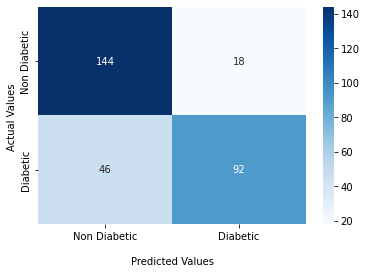

***************
Classification Report 
***************
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       162
           1       0.84      0.67      0.74       138

    accuracy                           0.79       300
   macro avg       0.80      0.78      0.78       300
weighted avg       0.79      0.79      0.78       300



True

In [107]:
report(best_knn_wf15_knn, params,False,False,False,data_arr_scaled_with_f15_median_test,target_arr_test)

Ensemble Methods

Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

params = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [80,100, 200, 300]
    }
model = RandomForestClassifier()
best_rf, best_rf_wf15_median, best_rf_wf15_knn = report(model, params)

***************
TRAINING
***************
***************
Model tuned with data not containing F15
***************
Mean F1 Score : 0.8228435849513802
RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=80)
***************
Model tuned with data containing F15 imputed with Median
***************
Mean F1 Score : 0.8536523784506382
RandomForestClassifier(max_depth=110, max_features=3, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=200)
***************
Model tuned with data containing F15 imputed with knn
***************
Mean F1 Score : 0.8503622196856832
RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=200)
***************
VALIDATE
***************
***************
F1 Score for data not containing F15
***************
0.7958477508650519
***************
F1 Score for data containing F15 imputed with Median
***

Voting Classifier

In [124]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RationalQuadratic



#Initializing two svc models

sv1 =  SVC(C=1000, gamma=0.01)
# sv2 =  SVC(C=100, gamma=0.01)
gpc = GaussianProcessClassifier(kernel=1*RationalQuadratic(1.0))

#Creating a list of models

models = [('SVM 1', sv1),('GPC', gpc)]

#Initialize a voting classifier 

voting_model = VotingClassifier(estimators = models)

best_vc, best_vc_wf15_median, best_vc_wf15_knn = report(voting_model, params,True,False,False,'','',False)

***************
TRAINING
***************
***************
Model tuned with data not containing F15
***************
Cross Validation Score: 0.8836909439872288
Test F1 Score:  0.881118881118881
***************
Model tuned with data containing F15 imputed with Median
***************
Cross Validation Score: 0.8784467314802129
Test F1 Score:  0.9148936170212766
***************
Model tuned with data containing F15 imputed with knn
***************
Cross Validation Score: 0.8967078179653442
Test F1 Score:  0.8780487804878048


***************
Confusion Matrix
***************


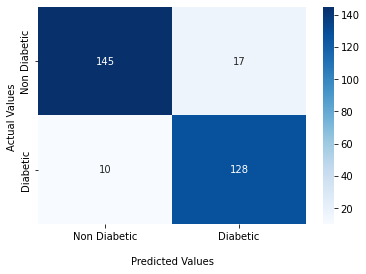

***************
Classification Report 
***************
              precision    recall  f1-score   support

           0       0.94      0.90      0.91       162
           1       0.88      0.93      0.90       138

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300



True

In [126]:
# Plot report for best performing model
report(best_vc_wf15_median, params,False,False,False,data_arr_scaled_with_f15_median_test,target_arr_test,False)

Comparative Study : Part b

In [109]:
test = pd.read_csv('CE802_P2_Data/CE802_P2_Test.csv')
print(test.shape)

(1500, 16)


In [110]:
# Transform the features using pipelin
# choose the voting classifier model as the best model
# store predictions in dataframe

_, y_test = df_to_array(test)
X_test = data_with_f15(test,True)
X_test_scaled = num_f15_pipeline_median.transform(X_test)
y_pred = best_vc_wf15_median.predict(X_test_scaled)
test.Class = np.where(y_pred == 1, True, False)
test.head()

(1500, 15) (1500,)


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Class
0,2,-38.31,1.62,248.04,-11.74,-9.25,-5.66,16.40,2.92,1.17,-13.14,2,-74.53,9.18,NaN,True
1,20,-24.03,11.40,629.04,-8.02,-5.35,-28.66,27.14,16.70,-10.56,-8.67,15,-14.53,2.06,NaN,False
2,2,-45.06,1.84,206.04,-11.73,-9.28,-7.66,15.94,1.70,-1.77,-20.37,3,-40.53,7.12,NaN,True
3,20,-22.35,18.30,539.04,-7.14,-4.15,-28.66,27.14,11.70,-14.97,-8.55,195,-29.53,1.46,-6.93,True
4,20,-22.47,10.70,749.04,-7.13,-4.60,-8.66,35.14,28.70,-12.33,-10.47,285,-74.53,-1.74,NaN,True


In [116]:
test['Class'].value_counts()

False    829
True     671
Name: Class, dtype: int64

In [117]:
test.to_csv('CE802_P2_Test_v1.csv',index=False)